In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from Post_utils import *
# from multi_exec import *
import torch
import time

import pickle
import dill
import shutil
import os

from metric import *
from model_graphsaint import GraphSAINT

from utils import *



### Neural layers

In [3]:
from torch import nn
import torch.nn.functional as F
import scipy.sparse as sp


F_ACT = {'relu': nn.ReLU(),
         'I': lambda x:x}


class HighOrderAggregator(nn.Module):
    """
        Graph convolution layer.
        Here each layer concatenate the embedding alongside the inputs
    """
    def __init__(self, dim_in, dim_out, dropout=0., act='relu', order=1, aggr='mean', bias='norm', **kwargs):
        super(HighOrderAggregator, self).__init__()
        
        self.order, self.aggr = order, aggr
        self.act, self.bias = F_ACT[act], bias
        self.dropout = dropout
        
        
        self.f_lin = list()
        self.f_bias = list()
        self.offset=list()
        self.scale=list()
        for o in range(self.order+1):
            self.f_lin.append(nn.Linear(dim_in,dim_out,bias=False))  # applies a linear transformation layer
            
            # mannuly initilaize the liearn layer initial values: 
            # Fills the input Tensor with values according to the method described in 
            # Understanding the difficulty of training deep feedforward neural networks - Glorot
            nn.init.xavier_uniform_(self.f_lin[-1].weight)   
            
            # Parameters are Tensor subclasses, that have a very special property when used with Module s - 
            # when they’re assigned as Module attributes they are automatically added to the list of its parameters,
            self.f_bias.append(nn.Parameter(torch.zeros(dim_out)))
            self.offset.append(nn.Parameter(torch.zeros(dim_out)))
            self.scale.append(nn.Parameter(torch.ones(dim_out)))
        
        # ModuleList can be indexed like a regular Python list, but modules it contains are properly registered, and will be visible by all Module methods.
        self.f_lin = nn.ModuleList(self.f_lin)  
        self.f_dropout = nn.Dropout(p=self.dropout)  # 
        
        # ParameterList can be indexed like a regular Python list, but parameters it contains are properly registered, and will be visible by all Module methods.
        self.params=nn.ParameterList(self.f_bias + self.offset + self.scale)
        
        # re-indexing each part of the ParameterList, just to make sure each list is now a nn.ParameterList
        self.f_bias=self.params[:self.order+1]
        self.offset=self.params[self.order+1:2*self.order+2]
        self.scale=self.params[2*self.order+2:]

    def _spmm(self, adj_norm, _feat):
        # alternative ways: use geometric.propagate or torch.mm
        
#         Performs a matrix multiplication of the sparse matrix mat1 and dense matrix mat2. Similar to torch.mm(), 
#         If mat1 is a (n \times m)(n×m) tensor, mat2 is a (m \times p)(m×p) tensor, out will be a (n \times p)(n×p) dense tensor. 
#         mat1 need to have sparse_dim = 2. This function also supports backward for both matrices. Note that the gradients of mat1 is a coalesced sparse tensor.
        return torch.sparse.mm(adj_norm, _feat)

    def _f_feat_trans(self, _feat, _id):
        # _id : the selected feature id
        feat=self.act(self.f_lin[_id](_feat) + self.f_bias[_id])
        
        # whether to apply the feature normalization after each layer forward func
        if self.bias=='norm':
            mean=feat.mean(dim=1).view(feat.shape[0], 1)   # mean values along axis 1 : viewed as N by 1 vector 
            var=feat.var(dim=1,unbiased=False).view(feat.shape[0],1) + 1e-9  # If unbiased is False, then the variance will be calculated via the biased estimator
            feat_out=(feat-mean)*self.scale[_id] * torch.rsqrt(var) + self.offset[_id]   # Returns a new tensor with the reciprocal of the square-root of each of the elements of input
        else:
            feat_out=feat   # for the last layer: i.e. classifier, no need for normalization
        return feat_out

    def forward(self, inputs):
        """
        Inputs:.
            adj_norm        edge-list represented adj matrix
        """
        adj_norm, feat_in = inputs
        # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution.
        feat_in = self.f_dropout(feat_in)
        
        feat_hop = [feat_in]
        # generate A^i X
        for o in range(self.order):
            # propagate(edge_index, x=x, norm=norm)
            feat_hop.append(self._spmm(adj_norm, feat_hop[-1]))
            
        feat_partial = [self._f_feat_trans(ft, idf) for idf, ft in enumerate(feat_hop)]
        
        if self.aggr == 'mean':
            feat_out = feat_partial[0]
            for o in range(len(feat_partial)-1):
                feat_out += feat_partial[o+1]
        elif self.aggr == 'concat':    # this is to concatenate the featuer tensors alongside with each other
            feat_out = torch.cat(feat_partial, 1)  # concatenate tensors alongside the columns
        else:
            raise NotImplementedError
        return adj_norm, feat_out       # return adj_norm to support Sequential


### network model

In [4]:
class GraphSAINT(nn.Module):
    """
        Trainer model
        Transfer data to GPU:   A  init:  1) feat_full   2) label_full   3) label_full_cat
    """
    def __init__(self, num_classes, arch_gcn, train_params, feat_full, label_full, cpu_eval=False):
        """
        Inputs:
            arch_gcn            parsed arch of GCN
            train_params        parameters for training
            cpu_eval (bool)  :   whether use CPU side for evalution
        """
        super(GraphSAINT,self).__init__()
        
        self.use_cuda = torch.cuda.is_available()
        if cpu_eval:
            self.use_cuda=False
        
        self.aggregator_cls=HighOrderAggregator
        self.mulhead=1
        
        # each layer in arch_gcn['arch']:  is a string separated by '-'
        self.num_layers = len(arch_gcn['arch'].split('-'))
        self.weight_decay = train_params['weight_decay']
        self.dropout = train_params['dropout']
        self.lr = train_params['lr']
        self.arch_gcn = arch_gcn
        
        # check if the task is a multi-label task
        # sigmoid: means this is a multi-label task
        self.sigmoid_loss = (arch_gcn['loss']=='sigmoid')   # use sigmoid for multi-label loss function
        
        self.feat_full = torch.from_numpy(feat_full.astype(np.float32))
        self.label_full = torch.from_numpy(label_full.astype(np.float32))
        
        
        self.num_classes = num_classes
        _dims, self.order_layer, self.act_layer, self.bias_layer, self.aggr_layer \
                        = parse_layer_yml(arch_gcn, self.feat_full.shape[1])
        
        # get layer index for each conv layer, useful for jk net last layer aggregation
        self.set_dims(_dims)

        self.loss = 0

        # build the model below        
        self.aggregators = self.get_aggregators()
        self.conv_layers = nn.Sequential(*self.aggregators)  # make sure the previous layer's output is the next one's output
        # calculate the final embeddings:
        self.classifier = HighOrderAggregator(self.dims_feat[-1], self.num_classes,\
                            act='I', order=0, dropout=self.dropout, bias='bias')
        
        self.optimizer = torch.optim.Adam(self.parameters(),lr=self.lr)

    def set_dims(self,dims):
        """
            dims_feat: Obtain the dimension of each embedding layer
            dims_weight:  Obtain the dimension of each weight
        """
        # dims[0] will the number of features
        # if using the concatenation as the feature aggration pattern, then need to count the dimension expansion
        self.dims_feat = [dims[0]] + [( (self.aggr_layer[l]=='concat') * self.order_layer[l] + 1) * dims[l+1] for l in range(len(dims)-1)]
        
        # set the current model weights dimensions, generated based on the embedding dimension:
        self.dims_weight = [(self.dims_feat[l], dims[l+1]) for l in range(len(dims)-1)]


    def forward(self, adj_subgraph, feat_subg):
        
        _, emb_subg = self.conv_layers((adj_subgraph, feat_subg))
        emb_subg_norm = F.normalize(emb_subg, p=2, dim=1)
        
        # obtain the prediction
        pred_subg = self.classifier((None, emb_subg_norm))[1]
        return pred_subg


    def _loss(self, preds, labels, norm_loss):
        """
            use the norm_loss as the weight factor
        """
        if self.sigmoid_loss:
            norm_loss = norm_loss.unsqueeze(1)
            return torch.nn.BCEWithLogitsLoss(weight = norm_loss,reduction='sum')(preds, labels)
        else:
            _ls = torch.nn.CrossEntropyLoss(reduction='none')(preds, labels)
            return (norm_loss * _ls).sum()


    def get_aggregators(self):
        """
        Return a list of aggregator instances. to be used in self.build()
        """
        aggregators = []
        for l in range(self.num_layers):
            aggrr = self.aggregator_cls(*self.dims_weight[l], dropout=self.dropout,\
                    act=self.act_layer[l], order=self.order_layer[l], \
                    aggr=self.aggr_layer[l], bias=self.bias_layer[l], mulhead=self.mulhead)
            aggregators.append(aggrr)
        return aggregators

    def predict(self, preds):
        return nn.Sigmoid()(preds) if self.sigmoid_loss else F.softmax(preds, dim=1)
        
        
    def train_step(self, node_subgraph, adj_subgraph, norm_loss_subgraph, feat_subg, label_subg_converted):
        """
        Purpose:  only count the time for the training process, including forward and backward propogation
        Forward and backward propagation
        norm_loss_subgraph : is the key to rescale the current batch/subgraph
        """
        self.train()
        # =============== start of the training process for one step: =================
        self.optimizer.zero_grad()
        # here call the forward propagation
        preds = self(adj_subgraph, feat_subg)    # will call the forward function
        loss = self._loss(preds, label_subg_converted, norm_loss_subgraph) # labels.squeeze()?
        
        # call the back propagation
        loss.backward()
        # any clipin ggradient optimization?
        torch.nn.utils.clip_grad_norm_(self.parameters(), 5)  #
#         Clips gradient norm of an iterable of parameters.
#         The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
        
        self.optimizer.step()
        # ending of the training process
        
        # also return the total training time and uploading time in seconds
        return loss, self.predict(preds)

    def eval_step(self, node_subgraph, adj_subgraph, norm_loss_subgraph):
        """
        Purpose: evaluation only on the CPU side
        Forward propagation only
        No backpropagation and thus no need for gradients
        """
        self.eval()
        feat_subg = self.feat_full[node_subgraph]
        label_subg = self.label_full[node_subgraph]
        
        if not self.sigmoid_loss:
            self.label_full_cat = torch.from_numpy(self.label_full.numpy().argmax(axis=1).astype(np.int64))
                
        label_subg_converted = label_subg if self.sigmoid_loss else self.label_full_cat[node_subgraph]
        
        with torch.no_grad():
            # only call the forward propagation
            print("during the evaluation step, report the input matrices size: ")
            print("adj_subgraph size :  {}; \t feat_subg size : {}".format(adj_subgraph.size(), feat_subg.size()) )

            preds = self(adj_subgraph, feat_subg)
            loss = self._loss(preds, label_subg_converted, norm_loss_subgraph)
            
        return loss, self.predict(preds), label_subg

### Partition_Graph func

In [5]:
"""Collections of partitioning functions."""

import time
import metis
import scipy.sparse as sp


def partition_graph(adj_full, target_nodes, num_clusters):
    """partition a graph by METIS into smaller mini-clusters
        Later these mini-clusters will be re-orginaized/combined into larger batches
    Input:
        adj_full (sp.csr_matrix): full adjacent matrix of the whole graph 
        target_nodes (np.array): to-be partitioned target nodes, usually the train_nodes
    """
    start_time = time.time()
    num_nodes = len(target_nodes)     # just the to-be partitioned target nodes
    num_all_nodes = adj_full.shape[0]   # all nodes in the graph
    
    neighbor_intervals = []
    neighbors = []
    edge_cnt = 0
    neighbor_intervals.append(0)
    train_adj_lil = adj_full[target_nodes, :][:, target_nodes].tolil()
    train_ord_map = dict()
    train_adj_lists = [[] for _ in range(num_nodes)]
    for i in range(num_nodes):
        rows = train_adj_lil[i].rows[0]
        # self-edge needs to be removed for valid format of METIS
        if i in rows:
            rows.remove(i)
        train_adj_lists[i] = rows
        neighbors += rows
        edge_cnt += len(rows)
        neighbor_intervals.append(edge_cnt)
        train_ord_map[target_nodes[i]] = i
        
    if num_clusters > 1:
        _, groups = metis.part_graph(train_adj_lists, num_clusters, seed=1)
    else:
        groups = [0] * num_nodes
        
    part_row = []
    part_col = []
    part_data = []
    parts = [[] for _ in range(num_clusters)]
    for nd_idx in range(num_nodes):
        gp_idx = groups[nd_idx]
        nd_orig_idx = target_nodes[nd_idx]
        # add nodes to each group inside the parts
        parts[gp_idx].append(nd_orig_idx)
    
        for nb_orig_idx in adj_full[nd_orig_idx].indices:
            nb_idx = train_ord_map[nb_orig_idx]
            if groups[nb_idx] == gp_idx:
                part_data.append(1)
                part_row.append(nd_orig_idx)
                part_col.append(nb_orig_idx)
    part_data.append(0)
    part_row.append(num_all_nodes - 1)
    part_col.append(num_all_nodes - 1)
    part_adj = sp.coo_matrix((part_data, (part_row, part_col))).tocsr()
    
    # parts: is the divided groups of nodes
    # part_adj: is the csr_matrix for the adjacency matrix of the whole graph
    # here this part_adj is different since some of the inter-cluster edges are lost
    return part_adj, parts


### Minibatch machine

In [8]:
import math
import scipy.sparse as sp
import scipy
import numpy as np

def _coo_scipy2torch(adj):
    """
    convert a scipy sparse COO matrix to torch
    
    Torch supports sparse tensors in COO(rdinate) format, which can efficiently store and process tensors 
    for which the majority of elements are zeros.
    A sparse tensor is represented as a pair of dense tensors: a tensor of values and a 2D tensor of indices. 
    A sparse tensor can be constructed by providing these two tensors, as well as the size of the sparse tensor 
    """
    values = adj.data
    indices = np.vstack((adj.row, adj.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    
    return torch.sparse.FloatTensor(i,v, torch.Size(adj.shape))


class Minibatch:
    """
        This minibatch iterator iterates over nodes for supervised learning.
        Data transferred to GPU:     A  init: 1) self.adj_full_norm;  2) self.norm_loss_test;
                                     B  set_sampler:  1) self.norm_loss_train
                                     C  one_batch : 1) subgraph adjacency matrix (adj)
    """

    def __init__(self, adj_full, adj_train, role, train_params, cpu_eval = False, mode = "train", 
                 num_clusters = 128, batch_num = 32):
        """
        role:       array of string (length |V|)
                    storing role of the node ('tr'/'va'/'te')
        """
        self.use_cuda = torch.cuda.is_available()
        if cpu_eval:
            self.use_cuda = False
        
        # store all the node roles as the numpy array:
        self.node_train = np.array(role['tr'])
        self.node_val = np.array(role['va'])
        self.node_test = np.array(role['te'])

        
        self.adj_train = adj_train
        print("adj train type is: {}; and shape is {}".format(type(adj_train), adj_train.shape))

        # norm_loss_test is used in full batch evaluation (without sampling). so neighbor features are simply averaged.
        self.norm_loss_test = np.zeros(adj_full.shape[0])
        
        _denom = len(self.node_train) + len(self.node_val) +  len(self.node_test)
        
        # instead of assign all elements of self.norm_loss_test to the same averaged denominator, separately assingment instead. 
        # does this mean there are other meaningless roles beyond: test, train and validation?
        self.norm_loss_test[self.node_train] = 1./_denom     
        self.norm_loss_test[self.node_val] = 1./_denom
        self.norm_loss_test[self.node_test] = 1./_denom
        self.norm_loss_test = torch.from_numpy(self.norm_loss_test.astype(np.float32))
            
        self.deg_train = np.array(self.adj_train.sum(1)).flatten()   # sum the degree of each train node, here sum along column for adjacency matrix
        
        # for train part: use the modified adjacency matrix: with inter-cluster edges broken
        if mode == "train": 
            self.adj_full, self.parts = partition_graph(adj_train, self.node_train, num_clusters)
            self.generate_norm_loss_train(num_clusters, batch_num)
            self.num_training_batches = batch_num
            self.num_mini_clusters = num_clusters
        else:
            self.adj_full = adj_full


    def generate_norm_loss_train(self, num_clusters, batch_num):
        """
            Train_phases (a dict defined in the .yml file) : usually including : end, smapler, size_subg_edge
            end:  number of total epochs to stop
            sampler: category for sampler (e.g. edge)
            size_subg_edge:  size of the subgraph in number of edges
        """
        self.norm_loss_train = np.zeros(self.adj_train.shape[0])

        self.norm_loss_train[self.node_train] += 1
        assert self.norm_loss_train[self.node_val].sum() + self.norm_loss_train[self.node_test].sum() == 0
        
        # normalize the self.norm_loss_train:
        self.norm_loss_train[np.where(self.norm_loss_train==0)[0]] = 0.1
        self.norm_loss_train[self.node_val] = 0
        self.norm_loss_train[self.node_test] = 0
        self.norm_loss_train[self.node_train] = batch_num/self.norm_loss_train[self.node_train]/self.node_train.size
        self.norm_loss_train = torch.from_numpy(self.norm_loss_train.astype(np.float32))

        
    def generate_train_batch(self, diag_lambda=-1):
        """
        Train batch Generator: Generate the batch for multiple clusters.
        """

        block_size = self.num_mini_clusters // self.num_training_batches
        np.random.shuffle(self.parts)  # each time shuffle different mini-clusters so that the combined batches are shuffled correspondingly
        
        for _, st in enumerate(range(0, self.num_mini_clusters, block_size)):
            # recombine mini-clusters into a single batch: pt
            node_subgraph = self.parts[st]
            for pt_idx in range(st + 1, min(st + block_size, self.num_mini_clusters)):
                node_subgraph = np.concatenate((node_subgraph, self.parts[pt_idx]), axis=0)
            
            norm_loss = self.norm_loss_train[node_subgraph]
            subgraph_adj = self.adj_full[node_subgraph, :][:, node_subgraph]

            # normlize subgraph_adj locally for each isolate subgraph
            if diag_lambda == -1:
                subgraph_adj = adj_norm(subgraph_adj, deg = self.deg_train[node_subgraph])
            else:
                subgraph_adj = adj_norm_diag_enhance(subgraph_adj, deg = self.deg_train[node_subgraph], diag_lambda = diag_lambda)
            subgraph_adj = _coo_scipy2torch(subgraph_adj.tocoo())
            
            yield (node_subgraph, subgraph_adj, norm_loss)    
    
    def generate_eval_batch(self):
        """
            Generate evaluation batch for validation/test procedures, whole graph 
        """
        node_subgraph = np.arange(self.adj_full.shape[0])  # include all the nodes inside the graph
        adj_full_norm = adj_norm(self.adj_full)  # return the normalized whole graph adj matrix; optional: diag_enhanced normalization: adj_norm_diag_enhance(...)
#             adj = adj_norm_diag_enhance(self.adj_full, diag_lambda = -1)
        adj_full_norm = _coo_scipy2torch(adj_full_norm.tocoo())

        return node_subgraph, adj_full_norm, self.norm_loss_test
            


### Basic execution components 

In [9]:
# define a lambda func
f_mean = lambda l: sum(l)/len(l)

def evaluate_full_batch(model, minibatch, mode='val'):
    """
        Full batch evaluation: for validation and test sets only.
        When calculating the F1 score, we will mask the relevant root nodes.
        mode: can be val or test
    """
    loss, preds, labels = model.eval_step(*minibatch.generate_eval_batch())
    node_val_test = minibatch.node_val if mode=='val' else minibatch.node_test
    # may not be necessary 
    f1_scores = calc_f1(to_numpy(labels[node_val_test]), to_numpy(preds[node_val_test]), model.sigmoid_loss)
    return loss, f1_scores[0], f1_scores[1]


def train_setting(dataname, datapath, train_config_file):
    """
        YAML (a recursive acronym for "YAML Ain't Markup Language") is a human-readable data-serialization language. 
        It is commonly used for configuration files and in applications where data is being stored or transmitted.
    
        yaml.load is as powerful as pickle.load and so may call any Python function. Check the yaml.safe_load function though.
        The function yaml.load converts a YAML document to a Python object.
    """
    with open(train_config_file) as f_train_config:
        train_config = yaml.load(f_train_config)
        
    arch_gcn = {'dim':-1,
                'aggr':'concat',
                'loss':'softmax',
                'arch':'1',
                'act':'I',
                'bias':'norm'}
    # check the loss:  default to be softmax, multi-class problem, each node can only belong to just one class at last
    arch_gcn.update(train_config['network'][0])   # train_config['network'] is a list of dict
    
    
    train_params = {'lr' : 0.01, 'weight_decay' : 0., 'norm_loss':True, 'norm_aggr':True, 'q_threshold' : 50, 'q_offset':0}
    train_params.update(train_config['params'][0])
    train_phases = train_config['phase']
    for ph in train_phases:
        assert 'end' in ph
        assert 'sampler' in ph
    print("Loading training data..")
    temp_data = load_data(dataname, datapath = datapath)
    train_data = process_graph_data(*temp_data)
    print("Done loading training data..")
    
    # train_data is a tuple: adj_full, adj_train, feats, class_arr, role
    return train_params, train_phases, train_data, arch_gcn

def prepare(working_dir, train_data, train_params, arch_gcn):
    """
        working_dir: main working dir for experiments
        train_params: contain settings for the mini-batch setting
        arch_gcn: contain all the settings 
    """
    adj_full, adj_train, feat_full, class_arr, role = train_data
    adj_full = adj_full.astype(np.int32)  # change the original np.bool into 0-1 ints
    adj_train = adj_train.astype(np.int32)
    
    num_classes = class_arr.shape[1]
    
    # key switch :  cpu_eval (bool)
    # establish two models, one for train, one for evaluation, because later the model_eval will load the trained model parameters
    
#     # for training process: on GPU
    minibatch = Minibatch(adj_full, adj_train, role, train_params, cpu_eval = False, mode = "train", num_clusters = 16, batch_num = 8)
    model = GraphSAINT(num_classes, arch_gcn, train_params, feat_full, class_arr)
    
    
    # for evaluation: validaiton/test  : on CPU
    minibatch_eval = Minibatch(adj_full, adj_train,role, train_params, cpu_eval=True, mode = "eval")
    model_eval = GraphSAINT(num_classes, arch_gcn, train_params, feat_full, class_arr, cpu_eval=True)
    
    if torch.cuda.is_available():
        model = model.cuda()
        
    # model, model_eval, mini_batch_eval can be saved as pickle file for use later

    ### but cannot pickle lambda func for now

    prepare_data_folder = working_dir + 'prepare_data/'
    os.makedirs(os.path.dirname(prepare_data_folder), exist_ok=True)

    train_input_file_name = prepare_data_folder + 'model_train_input'
    with open(train_input_file_name, "wb") as fp:
        dill.dump((minibatch, model), fp)
        

    evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
    with open(evaluation_input_file_name, "wb") as fp:
        dill.dump((minibatch_eval, model_eval), fp)
    
    # return model, minibatch, minibatch_eval, model_eval


def train_investigate(snap_model_folder, train_phases, model, minibatch, eval_train_every, snapshot_every = 10,
          mini_epoch_num = 5, multilabel = True, core_par_sampler = 1, samples_per_processor = 200):
    """
    PURPOSE:  to go through each training phase and take a snapshot of current mode and saved as pickle files
        snap_model_folder : folder to save the model snapshots during training
        train_phases:  use defined train fases defined in the .yml file
        model :  graphsaint model for training
        minibatch:   minibatch for training, usually with batches pool
        eval_train_every :  periodically store the train loss during the training process
        snapshot_every :  periodically store the states of the trained model for later evaluation
        mini_epoch_num :  how long the training will focus on one single batch
        multilabel : True if a multi-label task, otherwise a multi-class case
        core_par_sampler : how many CPU cores  will be used on each CPU
        samples_per_processor : how many samples will be generated from each CPU
    return: 1) total training time;  2) data uploading time
    
    """
    
    epoch_ph_start = 0
    time_train, time_upload, pure_time_train = 0, 0, 0
    
    # establish a new folder if it does not exist
    
#     os.makedirs(snap_model_folder, exist_ok = True)
    num_batches = minibatch.num_training_batches
    for ip, phase in enumerate(train_phases):
        printf('START PHASE {:4d}'.format(ip),style='underline')
        
#         print('calculated batch number is: ', num_batches)
        
        
        epoch_ph_end = int(phase['end'])
        macro_epoch_part_num = (epoch_ph_end - epoch_ph_start) // mini_epoch_num
        for macro_epoch_idx in range(macro_epoch_part_num):
            
            l_loss_tr, l_f1mic_tr, l_f1mac_tr = [], [], []
            
            actual_batch_num = 0
            
#             while not minibatch.end():
            # set the generator for all the one_batch
            train_batch_generator = minibatch.generate_train_batch(diag_lambda=-1)
            batch_idx = 0
            # iterate through the train batch generator:
            for node_subgraph, adj_subgraph, norm_loss_subgraph in train_batch_generator:
                
                ### =========== prepare for all the data to be used ==============
                feat_subg = model.feat_full[node_subgraph]
                label_subg = model.label_full[node_subgraph]
                
                if not multilabel:
                    # for the multi-class, need type conversion
                    label_full_cat = torch.from_numpy(model.label_full.numpy().argmax(axis=1).astype(np.int64))

                label_subg_converted = label_subg if multilabel else label_full_cat[node_subgraph]
                
                t0 = time.time()
                # transfer data to the GPU
                feat_subg = feat_subg.cuda()
                label_subg = label_subg.cuda()
                adj_subgraph = adj_subgraph.cuda()
                norm_loss_subgraph = norm_loss_subgraph.cuda()
                label_subg_converted = label_subg_converted.cuda()
                time_upload += time.time() - t0
                
                
                for micro_epoch_idx in range(mini_epoch_num):
                    real_epoch_idx = 1 + micro_epoch_idx + macro_epoch_idx * mini_epoch_num + epoch_ph_start
                    printf('Epoch {:4d}, Batch ID {}'.format(real_epoch_idx, batch_idx),style='bold')
                    # pure training process:
                    t1 = time.time()
                    loss_train, preds_train = \
                            model.train_step(node_subgraph, adj_subgraph, norm_loss_subgraph, feat_subg, label_subg_converted)
                    
                    pure_time_train += time.time() - t1
                    labels_train = label_subg
                    
                    # take a snapshot of current model for later validation
                    if batch_idx == num_batches - 1 and real_epoch_idx % snapshot_every == 0:
                        snap_model_file = snap_model_folder + 'snapshot_epoch_' + str(real_epoch_idx) + '.pkl'
                        torch.save(model.state_dict(), snap_model_file)  # store the current state_dict() into the file: 'tmp.pkl'
                    
                    
                        # periodically calculate all the statistics and store them
#                             if not minibatch.batch_num % eval_train_every:
                        # to_numpy already convert tensor onto CPU
                        f1_mic, f1_mac = calc_f1(to_numpy(labels_train), to_numpy(preds_train), model.sigmoid_loss)
                        l_loss_tr.append(loss_train)
                        l_f1mic_tr.append(f1_mic)
                        l_f1mac_tr.append(f1_mac)
                
                # increase the iteration index of the train batch generator 
                batch_idx += 1
            
            
        # for different training phase, train it continuously 
        epoch_ph_start = int(phase['end'])
        printf("Optimization Finished!", style="yellow")
    
    time_train = pure_time_train + time_upload
    # after going through all the training phases, print out the total time
    printf("Total training time: {:6.2f} ms".format(time_train * 1000), style='red')
    printf("Total train data uploading time: {:6.2f} ms".format(time_upload * 1000), style='red')
    
    return time_train * 1000, time_upload * 1000
            

def evaluate(snap_model_folder, minibatch_eval, model_eval, epoch_idx, mode='val'):
    """
        Perform the evaluation: either validaiton or test offline from saved snapshot of the models
        generate evaluation results from a single timepoint snapshot of the trained model
        return : micro_f1 score, macro_f1 score
        
    """
    ### location to output the evaluation result
    
    snap_model_file = snap_model_folder + 'snapshot_epoch_' + str(epoch_idx) + '.pkl'

    model_eval.load_state_dict(torch.load(snap_model_file, map_location=lambda storage, loc: storage))

    loss_val, f1mic_val, f1mac_val = evaluate_full_batch(model_eval, minibatch_eval, mode = mode)

    return f1mic_val, f1mac_val
    




### multi-execute

In [10]:
# multiexec module:
def execute_train_investigate(image_path, work_dir, train_phases, model, minibatch, eval_train_every, 
                              tune_param_name, tune_val_label, tune_val, trainer_id = 0,
                         snapshot_every = 5, mini_epoch_num = 5, multilabel = True, core_par_sampler = 1, samples_per_processor = 200):
    """
        return all validation-F1 for all four models
    """
    # run the training process for the model
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                        '/model_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(tune_model_folder), exist_ok=True)
    
    # to apply any tuning values
    total_time_train, time_upload = train_investigate(tune_model_folder, train_phases, model, minibatch, eval_train_every, 
                                    snapshot_every = snapshot_every, mini_epoch_num = tune_val, multilabel = multilabel, 
                              core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)
    
    time_info_folder = image_path + 'train_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(time_info_folder), exist_ok=True)
    
    time_info_file_name = time_info_folder + 'train_time'
    with open(time_info_file_name, "wb") as fp:
        pickle.dump((total_time_train, time_upload), fp)
            
    
def execute_validation_investigate(image_path, work_dir, minibatch_eval, model_eval, snapshot_epoch_list, 
                                 tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    """
        Perform the validaiton offline from saved snapshot of the models
        snapshot_epoch_list :  a list of the saved models to perform evaluation
    """
    
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    validation_res_folder = image_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/validation_trainer_' + str(trainer_id) + '/'
    
    os.makedirs(os.path.dirname(validation_res_folder), exist_ok=True)
    
    # start evaluation:
    for validation_epoch in snapshot_epoch_list:
        
        res = evaluate(tune_model_folder, minibatch_eval, model_eval, validation_epoch)
        
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "wb") as fp:
            pickle.dump(res, fp)

            
    
def execute_test_tuning(image_path, work_dir, minibatch_eval, model_eval, snapshot_epoch_list, 
                                 tune_param_name, tune_val_label, tune_val, trainer_id = 0):
    """
        1) After the validation, select the epoch with the best validation score
        2) use the trained model at the selected optimal epoch of validation
        3) perform the evaluate func for the test data
    """
    # start to search for the trained model epoch with the best validation f1 socre
    f1mic_best, ep_best = 0, -1
    validation_res_folder = image_path + 'validation_res/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/validation_trainer_' + str(trainer_id) + '/'
    
    for validation_epoch in snapshot_epoch_list:
        validation_res_file_name = validation_res_folder + 'model_epoch_' + str(validation_epoch)
        with open(validation_res_file_name, "rb") as fp:
            f1mic_val, f1mac_val = pickle.load(fp)
        
        if f1mic_val > f1mic_best:
            f1mic_best, ep_best = f1mic_val, validation_epoch
        
    # use the selected model to perform on the test
    tune_model_folder = work_dir + 'model_snapshot/tune_' + tune_param_name + '_' + str(tune_val_label) + \
                                    '/model_trainer_' + str(trainer_id) + '/'
    
    # return 1) micro-f1 ;  2) macro-f1
    res = evaluate(tune_model_folder, minibatch_eval, model_eval, ep_best, mode = 'test')
    
    # save the selected best saved snapshot
    best_model_file = tune_model_folder + 'snapshot_epoch_' + str(ep_best) + '.pkl'
    shutil.copy2(best_model_file, tune_model_folder + 'best_saved_snapshot.pkl')
    
    # store the resulting data on the disk
    test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val_label) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump(res, fp)
    
    
    


###  load data settings

In [11]:
datapath = '/home/xiangli/projects/tmpdata/GCN/GraphSaint/'

working_dir = './res_step0_all_in_one/'
prepare_data_folder = working_dir + 'prepare_data/'
img_path = working_dir + 'result/'

core_par_sampler = 1
samples_per_processor = -(-200 // core_par_sampler) # round up division
eval_train_every = 5  # period to record the train loss

### ================ Start to do flexible settings according to different dataset: 
# read the total epoch number from the yml file to determine the mini_epoch_num and eval_train_every
data_name = 'Flickr'
train_config_yml = './table2/flickr2_e.yml'
multilabel_tag = False

# data_name = 'PPI_small'
# train_config_yml = './table2/ppi2_e.yml'


tune_param_name = 'mini_epoch_num'
tune_val_label_list = [5] 
tune_val_list = [val for val in tune_val_label_list]

snapshot_period = 5   # period when to take a snapshot of the model for validation later

# refer to the yml file to decide the training period:
model_epoch_list = list(range(snapshot_period, 16, snapshot_period))    # snapshot epoch list for validation

trainer_list = list(range(1))

### prepare data

In [12]:
# =============== Step1 *** prepare for the batches, models, model_evaluation
train_params, train_phases, train_data, arch_gcn = train_setting(data_name, datapath, train_config_yml)


/home/xiangli/anaconda3/envs/pytorch_1_4_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:26: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Loading training data..
Done loading training data..


In [13]:

prepare(working_dir, train_data, train_params, arch_gcn)
train_phase_file_name = prepare_data_folder + 'model_train_phase'
with open(train_phase_file_name, "wb") as fp:
    dill.dump(train_phases, fp)

adj train type is: <class 'scipy.sparse.csr.csr_matrix'>; and shape is (89250, 89250)
adj train type is: <class 'scipy.sparse.csr.csr_matrix'>; and shape is (89250, 89250)


### Training process

In [15]:
# ============== Step2 *** conduct the training process
train_input_file_name = prepare_data_folder + 'model_train_input'
with open(train_input_file_name, "rb") as fp:
    minibatch, model = dill.load(fp)


train_phase_file_name = prepare_data_folder + 'model_train_phase'
with open(train_phase_file_name, "rb") as fp:
    train_phases = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_train_investigate(img_path, working_dir, train_phases, model, minibatch, eval_train_every, 
                                  tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id,
                                  snapshot_every = snapshot_period, mini_epoch_num = 5, multilabel = multilabel_tag, 
                                  core_par_sampler = core_par_sampler, samples_per_processor = samples_per_processor)


START PHASE    0


/home/xiangli/projects/GCN_program/largescale_GCN/HPC_version_GCN/22_clusterGCN_custom_hpc/gold_all_in_one/utils.py:184: RuntimeWarning: divide by zero encountered in true_divide
  norm_diag = sp.dia_matrix((1/D,0),shape=diag_shape)  # offset is 0


Epoch    1, Batch ID 0
Epoch    2, Batch ID 0
Epoch    3, Batch ID 0
Epoch    4, Batch ID 0
Epoch    5, Batch ID 0
Epoch    1, Batch ID 1
Epoch    2, Batch ID 1
Epoch    3, Batch ID 1
Epoch    4, Batch ID 1
Epoch    5, Batch ID 1
Epoch    1, Batch ID 2
Epoch    2, Batch ID 2
Epoch    3, Batch ID 2
Epoch    4, Batch ID 2
Epoch    5, Batch ID 2
Epoch    1, Batch ID 3
Epoch    2, Batch ID 3
Epoch    3, Batch ID 3
Epoch    4, Batch ID 3
Epoch    5, Batch ID 3
Epoch    1, Batch ID 4
Epoch    2, Batch ID 4
Epoch    3, Batch ID 4
Epoch    4, Batch ID 4
Epoch    5, Batch ID 4
Epoch    1, Batch ID 5
Epoch    2, Batch ID 5
Epoch    3, Batch ID 5
Epoch    4, Batch ID 5
Epoch    5, Batch ID 5
Epoch    1, Batch ID 6
Epoch    2, Batch ID 6
Epoch    3, Batch ID 6
Epoch    4, Batch ID 6
Epoch    5, Batch ID 6
Epoch    1, Batch ID 7
Epoch    2, Batch ID 7
Epoch    3, Batch ID 7
Epoch    4, Batch ID 7
Epoch    5, Batch ID 7
Epoch    6, Batch ID 0
Epoch    7, Batch ID 0
Epoch    8, Batch ID 0
Epoch    9,

### Investigate validation

In [16]:
# ================ Step3*** investigate validation:
evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
with open(evaluation_input_file_name, "rb") as fp:
    minibatch_eval, model_eval = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_validation_investigate(img_path, working_dir, minibatch_eval, model_eval, model_epoch_list, 
                                tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id)



during the evaluation step, report the input matrices size: 
adj_subgraph size :  torch.Size([89250, 89250]); 	 feat_subg size : torch.Size([89250, 500])
during the evaluation step, report the input matrices size: 
adj_subgraph size :  torch.Size([89250, 89250]); 	 feat_subg size : torch.Size([89250, 500])
during the evaluation step, report the input matrices size: 
adj_subgraph size :  torch.Size([89250, 89250]); 	 feat_subg size : torch.Size([89250, 500])


### Investigate test

In [17]:

# ================= Step4*** investigate test:
evaluation_input_file_name = prepare_data_folder + 'model_eval_input'
with open(evaluation_input_file_name, "rb") as fp:
    minibatch_eval, model_eval = dill.load(fp)

for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        execute_test_tuning(img_path, working_dir, minibatch_eval, model_eval, model_epoch_list, 
                                tune_param_name, tune_val_label, tune_val, trainer_id = trainer_id)

during the evaluation step, report the input matrices size: 
adj_subgraph size :  torch.Size([89250, 89250]); 	 feat_subg size : torch.Size([89250, 500])


### Post processing

Start summarizing for dataset : Flickr
Start running training for dataset: Flickr


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

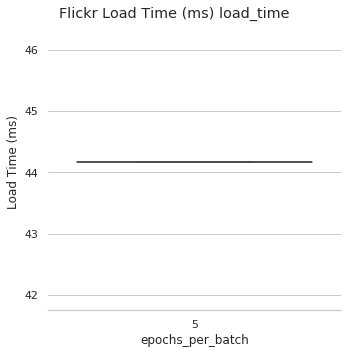

In [18]:
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step51_run_investigation_summarize_whole(data_name, img_path,
                                         tune_param_name, tune_val_label, tune_val,
                                            trainer_list, model_epoch_list)
    
for tune_val_label, tune_val in zip(tune_val_label_list, tune_val_list):
    for trainer_id in trainer_list:
        step50_run_tune_summarize_whole(data_name, img_path, 
                                    tune_param_name, tune_val_label_list, tune_val_list,
                                    trainer_list)